# Springboard--DSC Program

# Capstone Project 2 - Water Analytics 
### by Ellen A. Savoye

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages and data


In [86]:
!pip install pmdarima

In [87]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [88]:
import pickle
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import math
from datetime import datetime, date 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile
import glob

from statsmodels.tsa.stattools import adfuller

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
import pmdarima as pm

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [89]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_2/Code/"
dst = "/content/drive/My Drive/DS-Capstone_2/Data/"

In [90]:
# convert the 7 datasets to pickle
for filepath in glob.iglob(dst + '/Aquifer*.csv'):
    print(filepath)
    word = 'Aquifer'
    file_nm = filepath[filepath.find(word):]

    df = pd.read_csv(dst + file_nm)
    file_nm = file_nm[:file_nm.find('.csv')]
    with open(dst + file_nm + '.p', 'wb') as f:
        pickle.dump(df, f)

for filepath in glob.iglob(dst + '/Water_Spring*.csv'):
    # print(filepath)
    word = 'Water_Spring'
    file_nm = filepath[filepath.find(word):]

    df = pd.read_csv(dst + file_nm)
    file_nm = file_nm[:file_nm.find('.csv')]
    with open(dst + file_nm + '.p', 'wb') as f:
        pickle.dump(df, f)

/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Doganella.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Petrignano.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Luco.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Auser.csv


# Exploring Aquifer Petrignano

In [91]:
# Looking at 1 dataset - aquifer petrignano
Aq_Pet_df = pd.read_pickle(dst + 'Aquifer_Petrignano.p')

In [92]:
Aq_Pet_df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


**Features**

*   **Rainfall_Bastia_Umbra**: the quantity of rain falling (mm)
*   **Temperature**: the temperature (°C)
*   **Volume_C10_Petrignano**: the volume of water taken from the drinking water treatment plant (m^3)
*   **Hydrometry_Fiume_Chiascio_Petrignano**: the groundwater level (m)

**Targets**
*   **Depth_to_Groundwater_P24/Depth_to_Groundwater_P25**: groundwater level (m from the ground floor)

In [93]:
Aq_Pet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [94]:
Aq_Pet_df['Date'] = pd.to_datetime(Aq_Pet_df.Date, format = '%d/%m/%Y')

In [95]:
Aq_Pet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


In [96]:
Aq_Pet_df.shape

(5223, 8)

In [97]:
Aq_Pet_df['Year'], Aq_Pet_df['Month'] = Aq_Pet_df['Date'].dt.year, Aq_Pet_df['Date'].dt.month
Aq_Pet_df['Day'] = Aq_Pet_df['Date'].dt.day
Aq_Pet_df['Quarter'], Aq_Pet_df['Day_of_year'] = Aq_Pet_df['Date'].dt.quarter, pd.DatetimeIndex(Aq_Pet_df['Date']).dayofyear

In [98]:
Aq_Pet_df.isnull().sum(axis = 0)

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
Year                                       0
Month                                      0
Day                                        0
Quarter                                    0
Day_of_year                                0
dtype: int64

In [99]:
Aq_Pet_df.isnull().groupby([Aq_Pet_df['Year']]).sum()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,Year,Month,Day,Quarter,Day_of_year
Year,,,,,,,,,,,,,
2006,0,293,3,0,293,293,197,293,0,0,0,0,0
2007,0,365,2,2,365,365,0,365,0,0,0,0,0
2008,0,366,11,10,366,366,0,366,0,0,0,0,0
2009,0,0,0,0,0,0,0,0,0,0,0,0,0
2010,0,0,0,0,0,0,0,0,0,0,0,0,0
2011,0,0,0,0,0,0,0,0,0,0,0,0,0
2012,0,0,7,7,0,0,0,0,0,0,0,0,0
2013,0,0,21,0,0,0,0,0,0,0,0,0,0
2014,0,0,0,9,0,0,0,0,0,0,0,0,0


Prior to 2009, it appears rainfall, temperature, and hydrometry are missing. I will be removing the data prior to 01/01/2009 before continuing on.

In [100]:
# delete old rows with NA in feature to forecast 
nadate = dt.datetime(2008, 12, 31)
# print(nadate)
Aq_Pet_df = Aq_Pet_df[Aq_Pet_df.Date > nadate].reset_index(drop=True)

In [101]:
Aq_Pet_df.isnull().sum()

Date                                     0
Rainfall_Bastia_Umbra                    0
Depth_to_Groundwater_P24                39
Depth_to_Groundwater_P25                27
Temperature_Bastia_Umbra                 0
Temperature_Petrignano                   0
Volume_C10_Petrignano                    1
Hydrometry_Fiume_Chiascio_Petrignano     0
Year                                     0
Month                                    0
Day                                      0
Quarter                                  0
Day_of_year                              0
dtype: int64

Given the missing values in depth_to_groundwater, I am making a copy of my dataset to pursue the vein of thought to fill in the values using linear interpolation. My original dataset will be kept to potentially explore aggregating the data to either week or month view. 

In [102]:
# fill in missing values using linear interpolation? or have that as part of extended analysis??
# Using linear interpolation will carry some of the characteristics of neighbouring values - can be seen as a best estimate for the new missing pieces
Aq_Pet_df_daily = Aq_Pet_df.copy()
Aq_Pet_df_daily = Aq_Pet_df_daily.interpolate(method ='linear', limit_direction ='forward')

In [103]:
Aq_Pet_df_daily.rename(columns = {'Rainfall_Bastia_Umbra':'Rainfall', 'Depth_to_Groundwater_P24':'DG_P24', 'Depth_to_Groundwater_P25':'DG_P25',
                              'Temperature_Bastia_Umbra':'Temp_BU', 'Temperature_Petrignano':'Temp_P', 'Volume_C10_Petrignano':'Volume',
                              'Hydrometry_Fiume_Chiascio_Petrignano':'Hydrometry'}, inplace = True) 

Aq_Pet_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4199 non-null   datetime64[ns]
 1   Rainfall     4199 non-null   float64       
 2   DG_P24       4199 non-null   float64       
 3   DG_P25       4199 non-null   float64       
 4   Temp_BU      4199 non-null   float64       
 5   Temp_P       4199 non-null   float64       
 6   Volume       4199 non-null   float64       
 7   Hydrometry   4199 non-null   float64       
 8   Year         4199 non-null   int64         
 9   Month        4199 non-null   int64         
 10  Day          4199 non-null   int64         
 11  Quarter      4199 non-null   int64         
 12  Day_of_year  4199 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 426.6 KB


Before continuing on to check for other issues in the data, aside from NA values, I'm checking to see if the data is in chronoligical order with equidistant time intervals. For instance, I believe the data to be daily. The following will determine if I'm correct in that assumption.


In [104]:
Aq_Pet_df_daily = Aq_Pet_df_daily.sort_values(by='Date')

# Check time intervals
Aq_Pet_df_daily['Date_Delta'] = Aq_Pet_df_daily['Date'] - Aq_Pet_df_daily['Date'].shift(1)

In [105]:
Aq_Pet_df_daily['Date_Delta'].sum(), Aq_Pet_df_daily['Date_Delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

The data is in chronological order and the time interval is one day. 

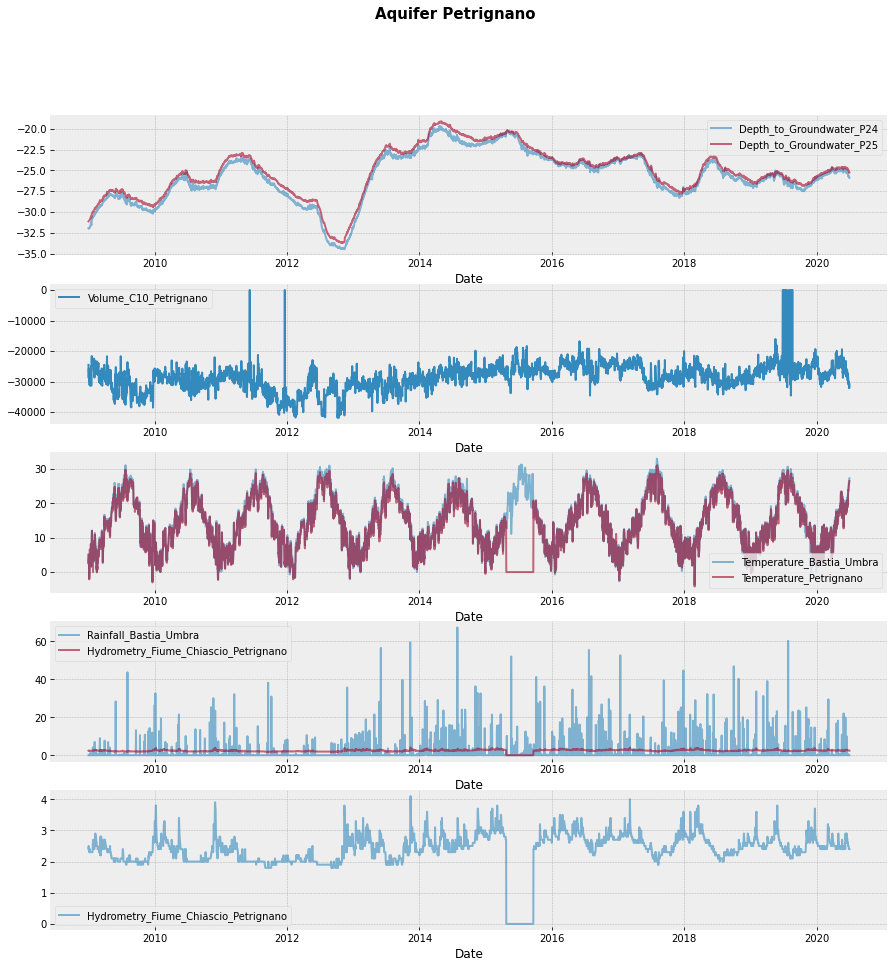

In [106]:
fig, ax = plt.subplots(5, 1, figsize = (15, 15))
plt.suptitle('Aquifer Petrignano', size = 15, fontweight = 'bold')

# check overlay of depth to groundwater variables
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='DG_P24', ax=ax[0], label='Depth_to_Groundwater_P24', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='DG_P25', ax=ax[0], label='Depth_to_Groundwater_P25', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Volume', ax=ax[1], label='Volume_C10_Petrignano')

# check overlay of temperature variables
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Temp_BU', ax=ax[2], label='Temperature_Bastia_Umbra', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Temp_P', ax=ax[2], label='Temperature_Petrignano', alpha=0.6)

# overlay hydrometry and rainfall
# Hydrometry indicates the groundwater level, expressed in meters (m), detected by the hydrometric station
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Rainfall', ax=ax[3], label='Rainfall_Bastia_Umbra', alpha=0.6)
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Hydrometry', ax=ax[3], label='Hydrometry_Fiume_Chiascio_Petrignano', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Hydrometry', ax=ax[4], label='Hydrometry_Fiume_Chiascio_Petrignano', alpha=0.6)

for i in ['top', 'right', 'bottom', 'left']:
  for y in [0, 1, 2, 3, 4]:
    ax[y].spines[i].set_visible(False)
    ax[y].set_ylabel('')

In 2015, we can see a dip in monthly temperatures for Temperature_Petrignano. This is likely due to missing values as the temperature distribution are almost identical to Temperature_Bastia_Umbra. The same dip is seen in the Hydrometry metric.

Given that these values did not show up as NA previously, I looked for zero values in all columns. There are a few in Volume and Temperature_Bastia_Umbra. However, both Temperature_Petrignano ad Hydrometry show a significant amount of missing data, appromixmately 5 months worth.

In [107]:
(Aq_Pet_df_daily == 0).sum()

Date              0
Rainfall       3147
DG_P24            0
DG_P25            0
Temp_BU           7
Temp_P          153
Volume           25
Hydrometry      150
Year              0
Month             0
Day               0
Quarter           0
Day_of_year       0
Date_Delta        0
dtype: int64

In [108]:
Aq_Pet_df_daily = Aq_Pet_df_daily.drop('Date_Delta', axis=1)

As there is over 10 years of data and the intent is to find the next consecutive day (or month) value, I'm comfortable in slimming the data down to 2016 and onward. I believe this data set will still be robust enough to provide an excellent training set.

In [109]:
# delete rows prior to 2016 
nadate = dt.datetime(2015, 12, 31)
# print(nadate)
Aq_Pet_df_daily = Aq_Pet_df_daily[Aq_Pet_df_daily.Date > nadate].reset_index(drop=True)

In [110]:
(Aq_Pet_df_daily == 0).sum()

Date              0
Rainfall       1105
DG_P24            0
DG_P25            0
Temp_BU           4
Temp_P            0
Volume           22
Hydrometry        0
Year              0
Month             0
Day               0
Quarter           0
Day_of_year       0
dtype: int64

Temp_BU and Volume both still have zero values. In the vein of prior thought, I will be replacing the zeroes with NAN to fill them using linear interpolation.

In [111]:
Aq_Pet_df_daily['Temp_BU'] = Aq_Pet_df_daily['Temp_BU'].replace(0, np.nan)
Aq_Pet_df_daily['Volume'] = Aq_Pet_df_daily['Volume'].replace(0, np.nan)

In [112]:
Aq_Pet_df_daily['Temp_BU'] = Aq_Pet_df_daily['Temp_BU'].interpolate(method ='linear', limit_direction ='forward')
Aq_Pet_df_daily['Volume'] = Aq_Pet_df_daily['Volume'].interpolate(method ='linear', limit_direction ='forward')

# Exploring Stationarity and Seasonality

Some time-series models, such as ARIMA, assumes the underlying data is stationary. Therefore, before applying any time-series models, stationarity needs to be checked. "[S]tationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time"1  

Noticable trends, seasonality, and changing levels are a few of the basic properties of non-stationary data. Looking at weekly temperature, we can clearly see prominent seasonality. Volume clearly shows noticable trend and changing levels.

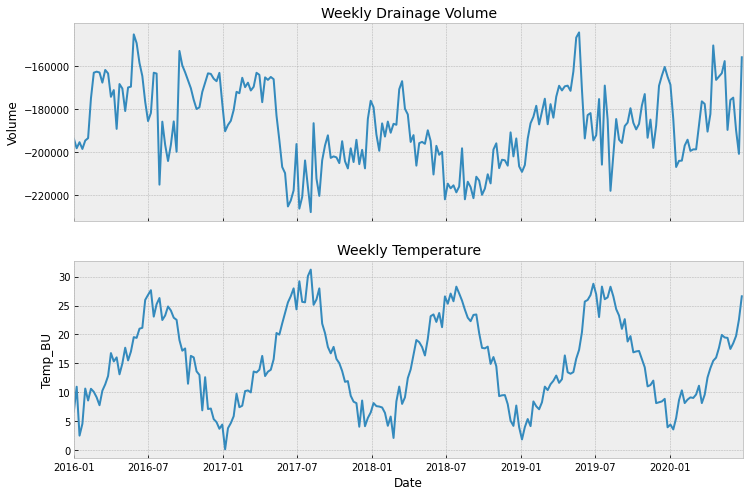

In [113]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,8))

resampled_aq = Aq_Pet_df_daily[['Date','Volume']].resample('7D', on='Date').sum().reset_index(drop=False)
sns.lineplot(resampled_aq['Date'], resampled_aq['Volume'], ax=ax[0])
ax[0].set_title('Weekly Drainage Volume', fontsize=14)

ax[0].set_xlim([date(2016, 1, 1), date(2020, 6, 30)])

resampled_aq = Aq_Pet_df_daily[['Date','Temp_BU']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_aq['Date'], resampled_aq['Temp_BU'], ax=ax[1])
ax[1].set_title('Weekly Temperature', fontsize=14)

for i in range(2):
    ax[i].set_xlim([date(2016, 1, 1), date(2020, 6, 30)])

Although the signs point to the data being non-stationary, I'm going to do the Dickey Fuller test. The test will help determine if the unit root is present in the series, which will help determine if the series is stationary or not.

**ADF Test**

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary.

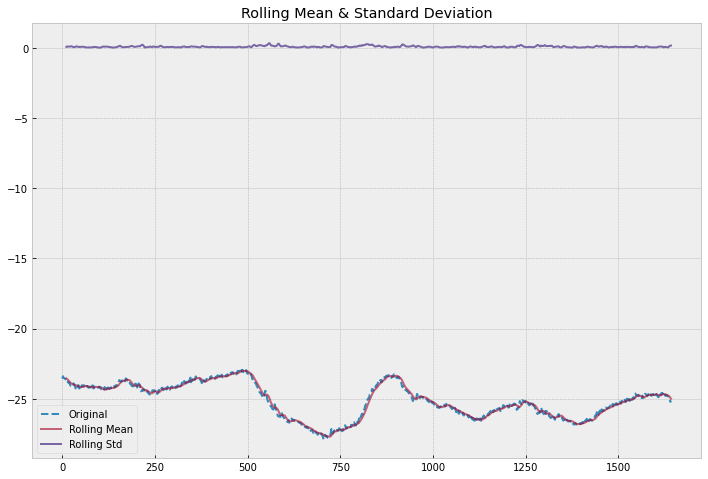

Results of Dickey-Fuller Test:
Test Statistic                   -2.447341
p-value                           0.128818
#Lags Used                       24.000000
Number of Observations Used    1618.000000
Critical Value (1%)              -3.434398
Critical Value (5%)              -2.863328
Critical Value (10%)             -2.567722
dtype: float64


In [114]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12,8))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25'], label='Original', linestyle='dashed')
mean = plt.plot(rolmean, label='Rolling Mean', alpha=0.6, linewidth=2)
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

**Test for stationarity** 

If the test statistic is greater than the critical value, we reject the null hypothesis which means the series is not stationary. If the test statistic is less than the critical value, we fail to reject the null hypothesis therefore the series is stationary.

Our test statistic is greater than the critical values. We reject the null hypothesis. Therefore, the series is not stationary.

Because time series, and ARIMA, requires data to be stationary, the data needs to be transformed. The data can be transformed using differencing or decomposition.
*   **Decomposition** – modeling both trend and seasonality and removing them from the model
*   **Differencing** – taking the differece with a particular time lag




We can break our time series up into pieces using decomposition. The pieces are as follows:

*   Seasonal - periodic up-and-downs in the data
*   Trend - pattern in the data spanning across seasonal periods
*   Cyclical - phenomena that happens across seasonal periods 2
*   Noise - random variation in the series

Seasonal, trend, and cyclical components can either be added or multiplied together.

*  Additive: y(t) = seasonal + trend + cyclical + noise
*  Multiplicative: y(t) = seasonal * trend * cyclical * noise

Using statsmodel, I'll be using the function seasonal_decompose() to piece apart my time series

In [115]:
# seasonal decomposition
# Date, Rainfall, DG_P24, DG_P25, Temp_BU, Temp_P, Volume, Hydrometry
keep_columns =  [
    'Rainfall', 'Temp_BU', 'Volume', 
    'Hydrometry', 'DG_P25'
]

for k_col in keep_columns:
    decomp = seasonal_decompose(Aq_Pet_df_daily[k_col], period=52, model='additive', extrapolate_trend='freq')
    Aq_Pet_df_daily[f"{k_col}_trend"] = decomp.trend
    Aq_Pet_df_daily[f"{k_col}_seasonal"] = decomp.seasonal
    Aq_Pet_df_daily[f"{k_col}_residual"] = decomp.resid

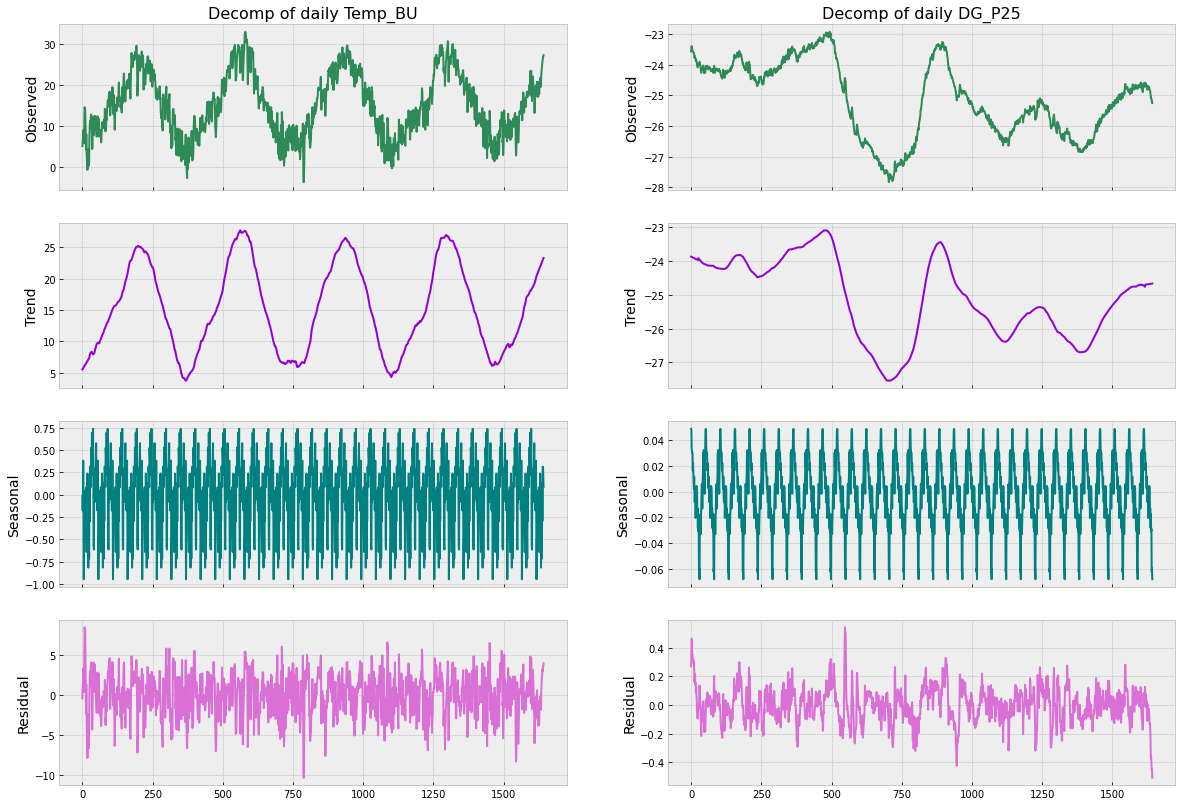

In [116]:
# visualize the change
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20,14))

for i, column in enumerate(['Temp_BU', 'DG_P25']):
    
    res = seasonal_decompose(Aq_Pet_df_daily[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomp of daily {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color= 'seagreen')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color= 'darkviolet')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color= 'teal')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color= 'orchid')
    ax[3,i].set_ylabel('Residual', fontsize=14)


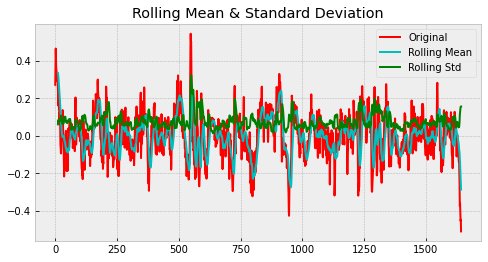

Results of Dickey-Fuller Test:
Test Statistic                -1.082606e+01
p-value                        1.755758e-19
#Lags Used                     2.000000e+00
Number of Observations Used    1.640000e+03
Critical Value (1%)           -3.434344e+00
Critical Value (5%)           -2.863304e+00
Critical Value (10%)          -2.567709e+00
dtype: float64


In [117]:
# testing stationarity on residuals from decomposition

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(8,4))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25_residual'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25_residual'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25_residual'], label='Original', color='r')
mean = plt.plot(rolmean, label='Rolling Mean', linewidth=2, color='c')
std = plt.plot(rolstd, label = 'Rolling Std', color='g')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25_residual'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Looking at my results for the ADF test on the residuals, I can see that decomposing my time series, by removing trend and seasonality, did not create a stationary series. 

### Differencing

For differencing, we take the difference of the observation at a particular instant with that at the previous instant. 

We will first be trying first order differencing.

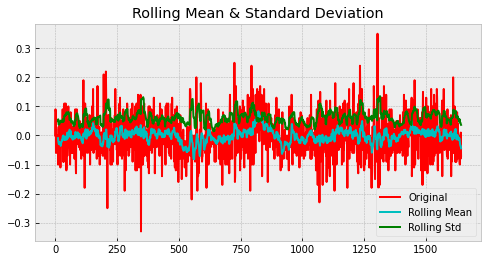

Results of Dickey-Fuller Test:
Test Statistic                   -4.787604
p-value                           0.000057
#Lags Used                       23.000000
Number of Observations Used    1619.000000
Critical Value (1%)              -3.434396
Critical Value (5%)              -2.863327
Critical Value (10%)             -2.567721
dtype: float64


In [118]:
# first order differencing
Aq_diff = np.diff(Aq_Pet_df_daily['DG_P25'])

Aq_Pet_df_daily['DG_P25_f1'] = np.append([0], Aq_diff)

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(8,4))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25_f1'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25_f1'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25_f1'], label='Original', color='r')
mean = plt.plot(rolmean, label='Rolling Mean', linewidth=2, color='c')
std = plt.plot(rolstd, label = 'Rolling Std', color='g')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25_f1'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

The test statistic is less than the critical values. We fail to reject the null hypothesis. Therefore, the series is now stationary.

In order to fit my ARIMA model, I need to determine what AR (p) or MA (q) are needed for my base model. By looking at autocorrelation and partial autocorrelation plots, ACF and PACF respectively, for my differenced series, I may be able to identify AR and MR that may be necessary for my ARIMA model. 

In [119]:
lag_acf = acf(Aq_Pet_df_daily['DG_P25_f1'], nlags=20)
lag_pacf = pacf(Aq_Pet_df_daily['DG_P25_f1'], nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

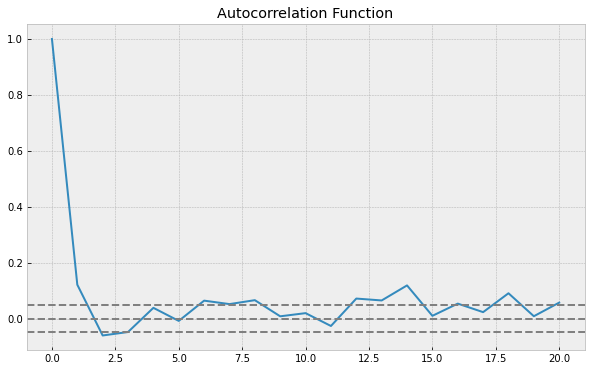

In [120]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(10,6))

#Plot ACF:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Aq_Pet_df_daily['DG_P25_f1'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Aq_Pet_df_daily['DG_P25_f1'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**q** – The lag value where the ACF chart crosses the upper confidence interval for the first time. In this case, it is around q=1.

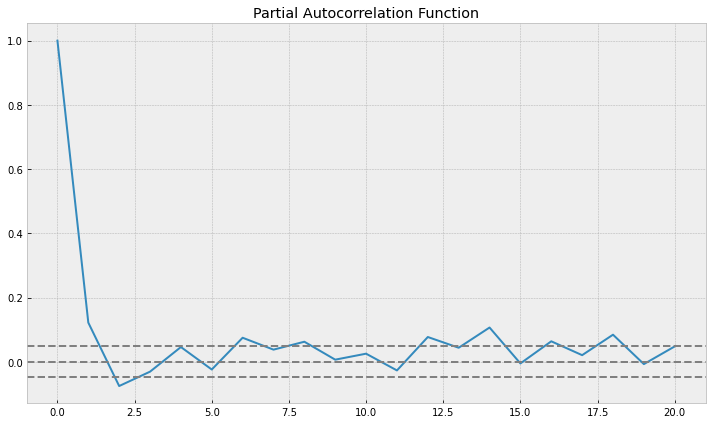

In [121]:
#Plot PACF:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(10,6))

plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Aq_Pet_df_daily['DG_P25_f1'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Aq_Pet_df_daily['DG_P25_f1'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**p** – The lag value where the PACF chart crosses the upper confidence interval for the first time. In this case, it is around p=1.

# Base Model - ARIMA (p, d, q)

In [122]:
# split into train/test for ARIMA

arima_df = Aq_Pet_df_daily[['Date', 'DG_P25']].copy()

test_size = 90
train_size = int(len(arima_df) - test_size)
data_size = len(arima_df)

train, test = arima_df[0:train_size], arima_df[train_size:]

# train = train.set_index('Date', drop=False)
# test = test.set_index('Date', drop=False)

X_train = pd.DataFrame(train.iloc[:, 0])
y_train = pd.DataFrame(train.iloc[:, 1])
y_arima_df = pd.DataFrame(arima_df.iloc[:, 1])

X_valid = pd.DataFrame(test.iloc[:, 0])
y_valid = pd.DataFrame(test.iloc[:, 1])

# X_valid = 
# y_valid_v2 = arima_df[train_size:].reset_index()

print(len(train), len(X_valid))

1553 90


In [123]:
# Fit model
# ARIMA(p, d, q)
# # p: Lag order (reference PACF in Autocorrelation Analysis)
# d: Degree of differencing. (reference Differencing in Stationarity)
# q: Order of moving average (check out ACF in Autocorrelation Analysis)
model_ar = ARIMA(y_train, order=(1,1,1))
model_fit_ar = model_ar.fit()

In [124]:
# Prediction with ARIMA 
y_pred_ar, se, conf = model_fit_ar.forecast(steps=test_size)

In [125]:
# Prediction with ARIMA 

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred_ar)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_ar))
score_mape = mean_absolute_percentage_error(y_valid, y_pred_ar)

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))
print('MAPE: {}'.format(score_mape))

MAE: 0.10114932474464974
RMSE: 0.1332850970692524
MAPE: 0.0040709744151989045


Around 0.4% MAPE implies the model is about 99.6% accurate in predicting the next 90 observations.

In [126]:
y_valid

,DG_P25
1553,-24.72
1554,-24.74
1555,-24.79
1556,-24.85
1557,-24.88
...,...
1638,-25.07
1639,-25.11
1640,-25.19
1641,-25.18


In [127]:
# summary of best model
print(model_fit_ar.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.DG_P25   No. Observations:                 1552
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2017.340
Method:                       css-mle   S.D. of innovations              0.066
Date:                Wed, 23 Jun 2021   AIC                          -4026.680
Time:                        00:53:41   BIC                          -4005.291
Sample:                             1   HQIC                         -4018.725
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0008      0.002     -0.400      0.689      -0.004       0.003
ar.L1.D.DG_P25    -0.1350      0.116     -1.161      0.246      -0.363       0.093
ma.L1.D.DG_P25     0.2718      0.111

                 0
count  1552.000000
mean     -0.000004
std       0.065977
min      -0.328266
25%      -0.040474
50%      -0.002612
75%       0.038526
max       0.349449


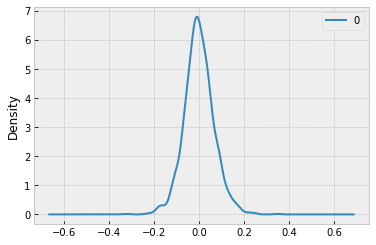

In [128]:
# residuals of ARIMA - daily data
residuals_ar = pd.DataFrame(model_fit_ar.resid)
residuals_ar.plot(kind='kde')
print(residuals_ar.describe())

In [129]:
y_pred_ar_df = pd.DataFrame(y_pred_ar, columns=['predicted'])
y_pred_ar_df.index = np.arange(1553, len(y_valid) + 1553)

Text(0, 0.5, 'Depth to Groundwater')

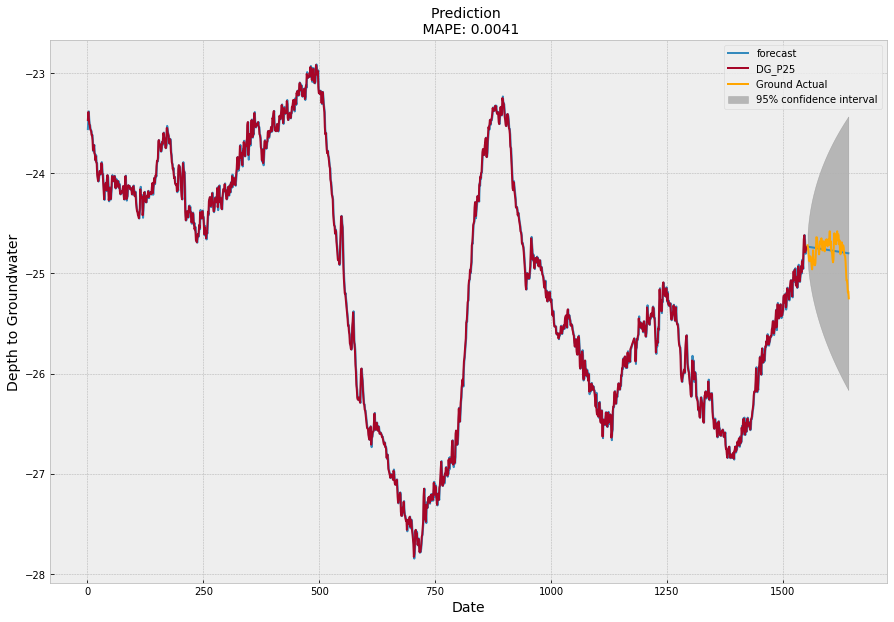

In [130]:
f, ax = plt.subplots(1, figsize=(15,10))

model_fit_ar.plot_predict(1, 1641, ax=ax)
sns.lineplot(x=X_valid.index, y=y_valid['DG_P25'], ax=ax, color='orange', label='Ground Actual')

ax.set_title(f'Prediction \n MAPE: {score_mape:.4f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

# Model #2 - Auto-ARIMA (p, d, q)

In [131]:
# Fit model
# Auto-ARIMA(p, d, q)
# # p: Lag order (reference PACF in Autocorrelation Analysis)
# d: Degree of differencing. (reference Differencing in Stationarity)
# q: Order of moving average (check out ACF in Autocorrelation Analysis)
# same train/valid set as ARIMA
model_aa = pm.auto_arima(y_train, 
                      test='adf',       # use adftest to find optimal 'd'
                      d=None,           # let model determine 'd'
                      seasonal=False)


print(model_aa.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1553
Model:               SARIMAX(3, 1, 4)   Log Likelihood                2061.504
Date:                Wed, 23 Jun 2021   AIC                          -4107.008
Time:                        00:55:06   BIC                          -4064.230
Sample:                             0   HQIC                         -4091.099
                               - 1553                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7009      0.064     11.032      0.000       0.576       0.825
ar.L2          0.9871      0.007    145.007      0.000       0.974       1.000
ar.L3         -0.7000      0.064    -11.018      0.0

In [132]:
# Prediction with Auto-ARIMA 
# Create predictions for the future, evaluate on test
y_pred_aa, conf_int = model_aa.predict(n_periods=test_size, return_conf_int=True)

In [133]:
# Prediction with Auto-ARIMA 

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred_aa)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_aa))
score_mape = mean_absolute_percentage_error(y_valid, y_pred_aa)

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))
print('MAPE: {}'.format(score_mape))

MAE: 0.3834684051935132
RMSE: 0.4290947700002089
MAPE: 0.015447439841314825


<function matplotlib.pyplot.close>

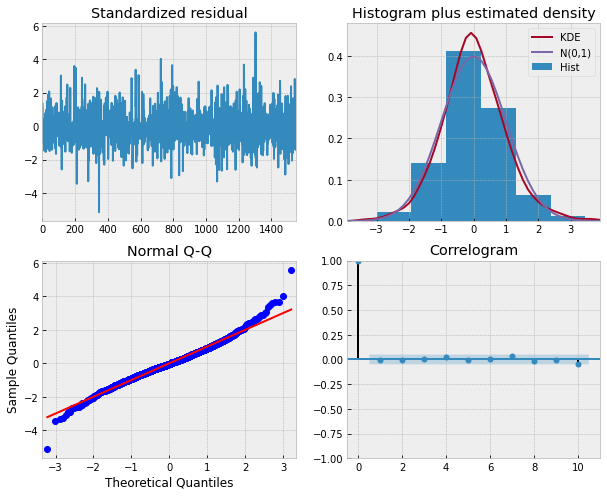

In [134]:
model_aa.plot_diagnostics(figsize=(10,8))
plt.close

In [135]:
residuals_aa = pd.DataFrame(model_aa.resid())

                 0
count  1553.000000
mean     -0.015255
std       0.601270
min     -23.560000
25%      -0.039098
50%      -0.002368
75%       0.037956
max       0.358984


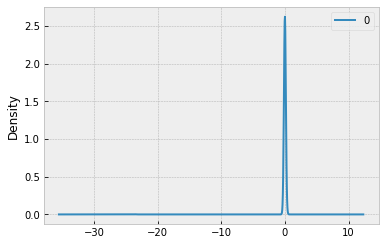

In [136]:
# residuals of ARIMA - daily data
residuals_aa.plot(kind='kde')
print(residuals_aa.describe())

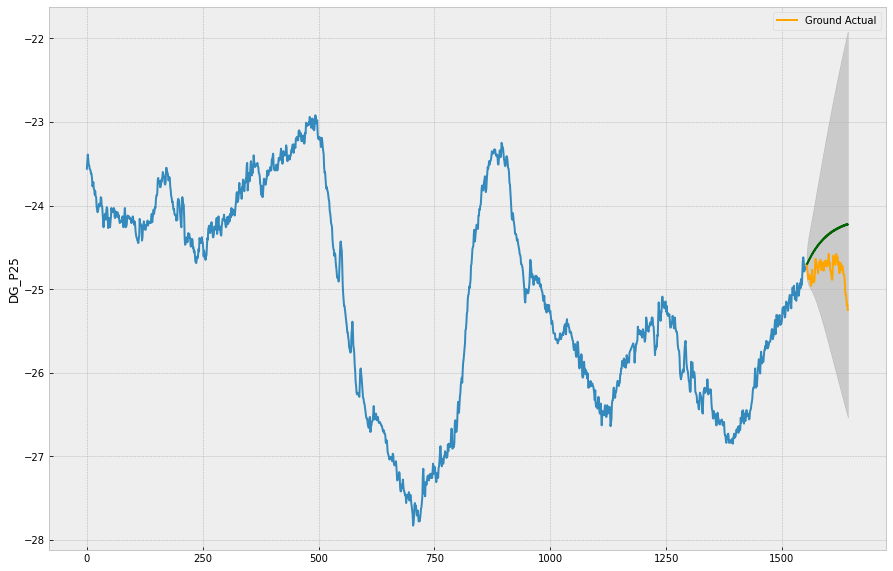

In [137]:
# Forecast
f, ax = plt.subplots(1, figsize=(15,10))
fc, confint = model_aa.predict(n_periods=test_size, return_conf_int=True)
index_of_fc = np.arange(len(y_train), len(y_train)+test_size)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(y_train)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
sns.lineplot(x=X_valid.index, y=y_valid['DG_P25'], ax=ax, color='orange', label='Ground Actual')


# Model #3 - Prophet

In [138]:
# FB Prophet data

train_p = train.copy()
train_p.columns = ['ds', 'y']

X_train_p = X_train.copy()
y_train_p = y_train.copy()
X_valid_p = X_valid.copy()
y_valid_p = y_valid.copy()

# adjust column names for prophet
X_train_p.columns = ['ds']
y_train_p.columns = ['y']
X_valid_p.columns = ['ds']
y_valid_p.columns = ['y']


In [139]:
# Fit model
# FB Prophet

# Train the model
model_p = Prophet()
model_p.fit(train_p)

future = model_p.make_future_dataframe(periods=test_size)

# Predict on valid set
forecast_p = model_p.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


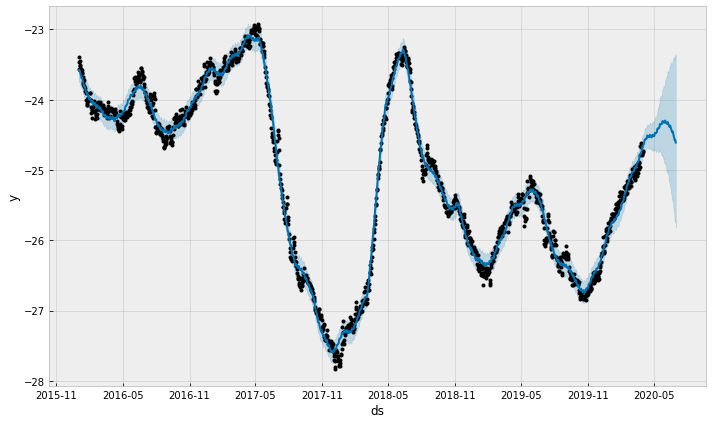

In [140]:
fig1 = model_p.plot(forecast_p)

In [141]:
# Calcuate metrics
y_valid_p = pd.DataFrame(arima_df.iloc[:, 1])
y_valid_p.columns = ['y']

y_pred_p = forecast_p['yhat'].values
score_mae = mean_absolute_error(y_valid_p, y_pred_p)
score_rmse = math.sqrt(mean_squared_error(y_valid_p, y_pred_p))
score_mape = mean_absolute_percentage_error(y_valid_p, y_pred_p)

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))
print('MAPE: {}'.format(score_mape))

MAE: 0.107152755655218
RMSE: 0.14199275700954575
MAPE: 0.004275326061044402


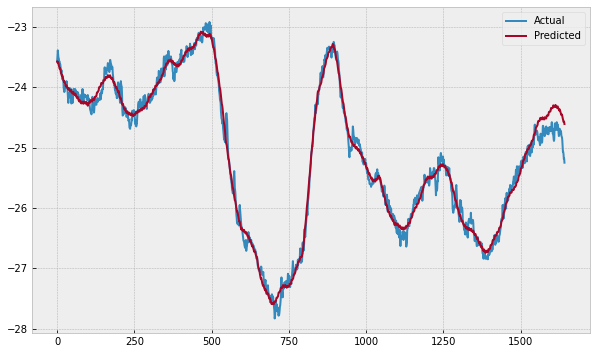

In [142]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(10,6))

plt.plot(y_valid_p, label='Actual')
plt.plot(y_pred_p, label='Predicted')
plt.legend()

In [143]:
residuals_ar

,0
1,0.090751
2,0.068803
3,-0.067018
4,-0.049039
5,-0.003923
...,...
1548,-0.111855
1549,0.029046
1550,0.008849
1551,0.014338


In [144]:
forecast_p.loc[:, 'errors'] = forecast_p.loc[:, 'yhat'] - y_valid_p.loc[:, 'y']

errors_mean = forecast_p['errors'].mean()
errors_std = forecast_p['errors'].std()

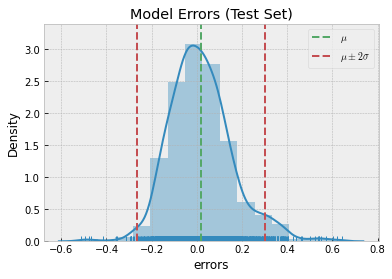

In [145]:
forecast_p.loc[:, 'errors'] = forecast_p.loc[:, 'yhat'] - y_valid_p.loc[:, 'y']

errors_mean = forecast_p['errors'].mean()
errors_std = forecast_p['errors'].std()

sns_c = sns.color_palette(palette='deep')
fig, ax = plt.subplots()

sns.distplot(a=forecast_p['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

# Comparing All 3 Models

In [146]:
y_pred_p_comparison = pd.DataFrame(y_pred_p)[train_size:]

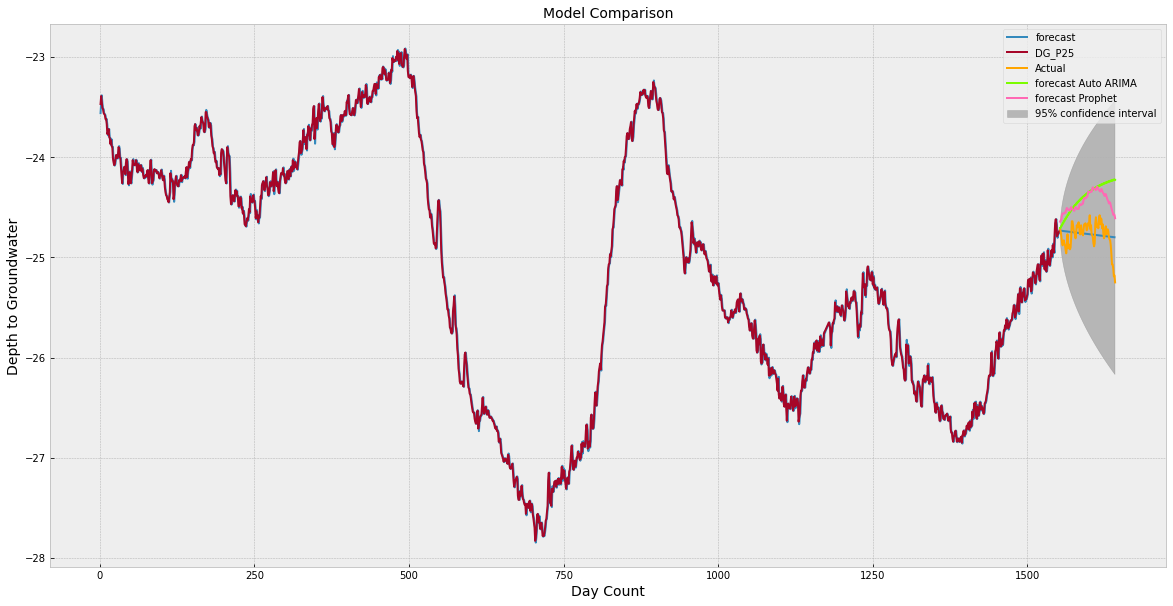

In [147]:
# predictions
f, ax = plt.subplots(1, figsize=(20,10), sharex=True)

model_fit_ar.plot_predict(1, 1641, ax=ax)
sns.lineplot(x=X_valid.index, y=y_valid['DG_P25'], ax=ax, color='orange', label='Actual')
plt.plot(fc_series, color='lawngreen', label='forecast Auto ARIMA')
plt.plot(y_pred_p_comparison, color='hotpink', label='forecast Prophet')


ax.set_title('Model Comparison', fontsize=14)
ax.set_xlabel(xlabel='Day Count', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
plt.legend()

In [148]:
df = residuals_ar.merge(residuals_aa, left_index=True, right_index=True)
forecast_prophet = forecast_p[0:train_size]
df = df.merge(forecast_prophet['errors'], left_index=True, right_index=True)
df.columns = ['ARIMA', 'Auto ARIMA', 'Prophet']

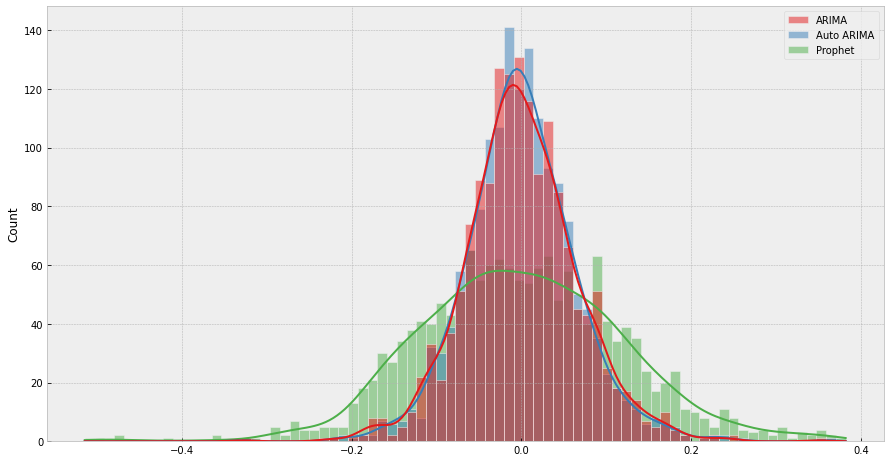

In [149]:
f, ax = plt.subplots(1, figsize=(15,8), sharex=True)

sns.histplot(data=df, ax=ax, kde=True, palette='Set1')

1. https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20t%20he%20most%20intuitive,not%20itself%20change%20over%20time
2. https://towardsdatascience.com/what-is-time-series-decomposition-and-how-does-it-work-9b67e007ae90